In [3]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))

library(repr)
library(kmed)
library(R.matlab)
library(ggplot2)
library(TDA)
library(dbscan)
library(stringr)
library(cluster)
library(factoextra)
library(Rtsne)
library(pracma)

set.seed(1337)

In [4]:
labels <- read.csv('simulations_labelled.csv')

In [5]:
ncols <- length(labels)
nrows <- length(labels$icR)
num_completed <- 220

In [6]:
crocker_folder <- 'CrockerPlots'
order_folder <- 'OrderParams'
raw_folder <- 'June_20_2018'
filesep <- .Platform$file.sep

ML_data = list()
ML_data$posfeat <- matrix(data=NA, nrow=num_completed, ncol=8282)
ML_data$velfeat <- matrix(data=NA, nrow=num_completed, ncol=8282)
ML_data$fullfeat <- matrix(data=NA, nrow=num_completed, ncol=8282)
ML_data$orderfeat <- matrix(data=NA, nrow=num_completed, ncol=404)

ML_data$category <- rep('label', num_completed)

for (i in seq(1, nrows)){
    
    icR <- labels$icR[i] 
    ilR <- labels$ilR[i]
    iR <- labels$iR[i]
    label <- labels$class[i]
    completed <- labels$completed[i]
    
    rawdatapath <- paste0(raw_folder, filesep, 'data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '.mat')
    rawdatafileinfo <- file.info(rawdatapath)
    
    if ((rawdatafileinfo$size/(1024*1024)) < 10){
        next
    }
    
    filepath <- paste0(crocker_folder, filesep, 'data_icR_', icR, '_ilR_', ilR)
    posfilename <- paste0('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '_CP_pos.csv')
    velfilename <- paste0('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '_CP_vel.csv')
    fullfilename <- paste0('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '_CP_full.csv')
    
    crocker_pos <- read.csv(paste0(filepath, filesep, posfilename))
    crocker_vel <- read.csv(paste0(filepath, filesep, velfilename))
    crocker_full <- read.csv(paste0(filepath, filesep, fullfilename))
    
    cmaxTime <- max(crocker_pos$time)
    cminTime <- min(crocker_pos$time) ## Can change cutoff
    timeBool <- (crocker_pos$time <= cmaxTime & crocker_pos$time >= cminTime)
    
    betti_dim_0 <- crocker_pos[which(crocker_pos$dimension==0 & timeBool), 5]
    betti_dim_1 <- crocker_pos[which(crocker_pos$dimension==1 & timeBool), 5]
    pos_feat_vec <- c(betti_dim_0, betti_dim_1)
    
    betti_dim_0 <- crocker_vel[which(crocker_vel$dimension==0 & timeBool), 5]
    betti_dim_1 <- crocker_vel[which(crocker_vel$dimension==1 & timeBool), 5]
    vel_feat_vec <- c(betti_dim_0, betti_dim_1)
    
    betti_dim_0 <- crocker_full[which(crocker_full$dimension==0 & timeBool), 5]
    betti_dim_1 <- crocker_full[which(crocker_full$dimension==1 & timeBool), 5]
    full_feat_vec <- c(betti_dim_0, betti_dim_1)
    
    ML_data$posfeat[i,] <- pos_feat_vec
    ML_data$velfeat[i,] <- vel_feat_vec
    ML_data$fullfeat[i,] <- full_feat_vec
    ML_data$category[i] <- toString(label)
    
    filepath <- paste0(order_folder, filesep, 'data_icR_', icR, '_ilR_', ilR)
    orderfilename <- paste0('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '_order_params.csv')
    order_params <- read.csv(paste0(filepath, filesep, orderfilename), header=FALSE)
    
    order_params_time <- order_params$V1
    omaxTime <- max(order_params_time)
    ominTime <- min(order_params_time)
    order_param_subset <- order_params[which(order_params$V1 <= omaxTime & order_params$V1 >= ominTime),]
    
    polarization <- order_param_subset$V2
    ang_moment <- order_param_subset$V3
    abs_ang_moment <- order_param_subset$V4
    mean_nnd <- order_param_subset$V5
    
    ML_data$orderfeat[i,] <- c(polarization, ang_moment, abs_ang_moment, mean_nnd) 
    
}

#### Classify order parameters using k-medoids algorithm
- Consider the last time-step
- Consider only completed simualtions

In [7]:
#summary(ML_data$orderfeat)
scaled_order_feats <- scale(ML_data$orderfeat)
#summary(scaled_order_feats)
feat_dims <- dim(scaled_order_feats)
print(feat_dims)

[1] 220 404


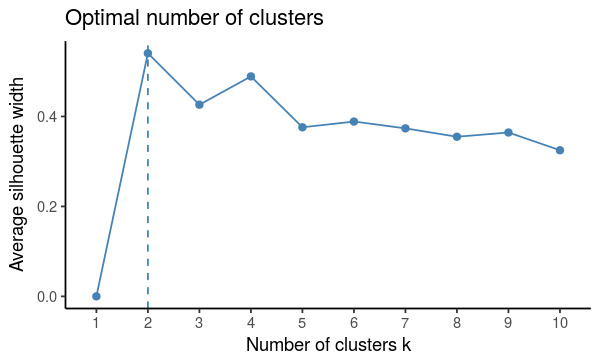

In [8]:
options(repr.plot.width=5, repr.plot.height=3)
fviz_nbclust(scaled_order_feats, pam, method = "silhouette") + theme_classic()

In [9]:
print(unique(ML_data$category))

[1] "single_mill" "double_mill" "clump"       "escape"     


In [29]:
pam.res <- pam(scaled_order_feats, 5, metric = "euclidean", stand = FALSE)

In [30]:
length(which(pam.res$clustering == 1))

[1] 76

In [31]:
medoids <- pam.res$id.med
for (j in seq(1, length(medoids))){
    print(paste(medoids[j], pam.res$clustering[medoids[j]], ML_data$category[medoids[j]]))
}

[1] "56 1 single_mill"
[1] "66 2 double_mill"
[1] "108 3 escape"
[1] "202 4 escape"
[1] "148 5 escape"


In [32]:
cluster_assignment <- pam.res$clustering

In [33]:
medoids_id <- pam.res$id.med

#for (j in c(seq(1, length(ML_data$category)))){
#    
#    print(paste(j, ML_data$category[j]))
#}

print(medoids_id)

[1]  56  66 108 202 148


In [36]:
uniq_classes <- c('single_mill', 'double_mill', 'clump', 'escape', 'catastrophic')
uniq_assignments <- c(1, 2, 4, 3, 5) 
confusion_mat <- data.frame(matrix(data=0, nrow=5, ncol=5))

names(confusion_mat) <- uniq_classes
row.names(confusion_mat) <- uniq_classes

correct <- 0
total <- 0

for (cnt in seq(1, length(cluster_assignment))){
    
    cid <- cluster_assignment[cnt]
    
    class <- 'label'
    if (cid == 1){
        class <- 'single_mill'
    } else if (cid == 2){
        class <- 'catastrophic'
    } else {
        class <- 'escape'
    }
    
    cat <- ML_data$category[cnt]
    
    if (strcmp(class, cat)){
        correct <- correct + 1
    }
    total <- total + 1
    
    col_idx <- match(cid, uniq_assignments)
    row_idx <- match(cat, uniq_classes)
    
    confusion_mat[row_idx, col_idx] <- confusion_mat[row_idx, col_idx] + 1
    confusion_mat[col_idx, row_idx] <- confusion_mat[col_idx, row_idx] + 1
    
}
print(correct/total)

[1] 0.8363636


In [37]:
# Rows are true categories
# Columns are k-medoids classification
confusion_mat

,single_mill,double_mill,clump,escape,catastrophic
single_mill,116,0,18,0,0
double_mill,0,36,0,0,0
clump,18,0,0,44,0
escape,0,0,44,136,14
catastrophic,0,0,0,14,0


In [39]:
dist_mat <- distNumeric(scaled_order_feats, scaled_order_feats, method = "se")
dim(dist_mat)[1]

[1] 220

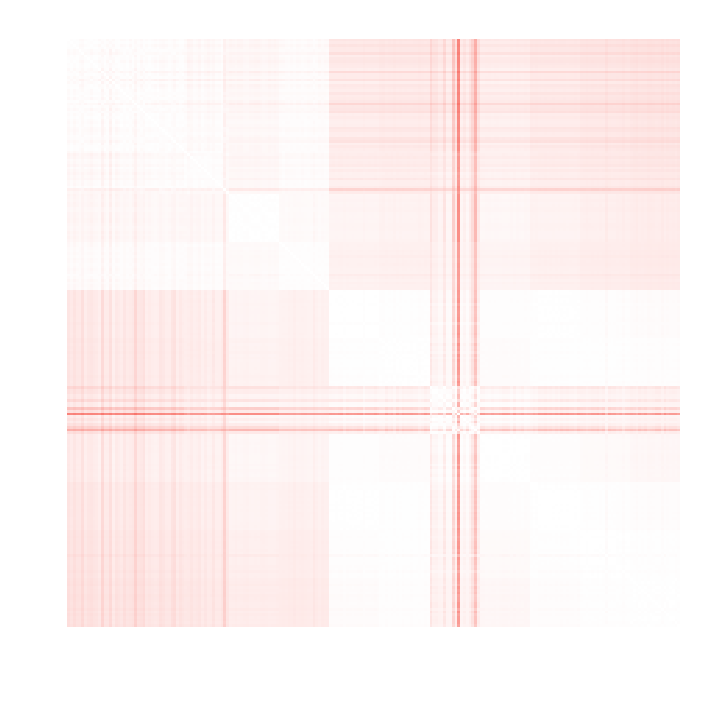

In [40]:
options(repr.plot.width=6, repr.plot.height=6)
clustheatmap(dist_mat)